# Start kit for Task 2 - Motor imagery decoding transfer learning challenge


We recommand you to read the 'LeaderboardDataGuide' and visit the https://beetl.ai to get familar with data and tasks before you read this start kit.

<p> &#10071; <b>Important</b> &#10071; </p>
For the competition, please MAKE SURE that your model and uploaded labels are reproducible. We will run winner's code and generate the label to compare with the uploaded labels.


## Objective of the tutorial

In this start kit, we will show how to use [MOABB](http://moabb.neurotechx.com/docs/index.html) to load `BNCI2014001`, `Cho2017` and `PhysionetMI` motor imagery datasets for the cross-dataset and cross-subject challenge. We also show an example pipeline of the challenge including:

- Environment setup
- Source motor imagery datasets loading
- Source and target domain data organisation
- Training and evaluation procedure using an example shallow CNN, using [BrainDecode](https://braindecode.org)

References:

> <p>&#128218;  Schirrmeister, Robin Tibor, et al. "Deep learning with convolutional neural networks for EEG decoding and visualization." Human brain mapping 38.11 (2017): 5391-5420. </p>

## Environment Setup

1. Install pytorch from http://pytorch.org/ (you don't need to install torchvision).
1. Install MOABB with pip: `pip install moabb`
1. Install latest release of braindecode via pip: `pip install braindecode`
1. You will also need mne, matplotlib, scikit-learn and pandas
1. If you want to automatically download the data, you could install the helper code with `pip install git+https://github.com/sylvchev/beetl-competition`

Let's import packages and set random seed. 

In [1]:
%matplotlib inline

In [2]:
from braindecode.util import set_random_seeds, np_to_var, var_to_np
import matplotlib.pyplot as plt
from moabb.datasets import BNCI2014001, Cho2017, PhysionetMI
from moabb.paradigms import MotorImagery
import numpy as np
from numpy.random import RandomState
import pickle
import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import mne

import util.shallow_net
from util.utilfunc import get_balanced_batches
from util.preproc import plot_confusion_matrix

cuda = torch.cuda.is_available()
print('gpu: ', cuda)
device = 'cuda' if cuda else 'cpu'

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
rng = RandomState(seed)

/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


gpu:  False


To download source MI datasets, we will use MOABB. By default, the datasets are downloaded in a `mne_data` folder in your home directory. To change this default repository, uncomment the next lines of codes and indicate the chosen path.

In [3]:
# from moabb.utils import set_download_dir
# set_download_dir("/path/to/my/datasets")

The next blocks download the data from the first subject of `BNCI2014001`, `Cho2017`, `PhysionetMI` and print information regarding the data.

In [4]:
# subj = 1
# for dataset in [BNCI2014001(), PhysionetMI(), Cho2017()]:
#     data = dataset.get_data(subjects=[subj])
#     ds_name = dataset.code
#     ds_type = dataset.paradigm
#     sess = 'session_T' if ds_name == "001-2014" else 'session_0'
#     run = sorted(data[subj][sess])[0]
#     ds_ch_names = data[subj][sess][run].info['ch_names']  # [0:22]
#     ds_sfreq = data[subj][sess][run].info['sfreq']
#     print("{} is an {} dataset, acquired at {} Hz, with {} electrodes\nElectrodes names: ".format(ds_name, ds_type, ds_sfreq, len(ds_ch_names)))
#     print(ds_ch_names)
#     print()

# Loading MI Data

We will use the first 3 subjects of `Cho2017` and first 5 subjects of `PhysionetMI` as the source data and we will use the first subject from `BNCI2014001` as the target subject we would like to transfer to. We directly regard trials other than left/right hand MI as 'other' and train them together, you could come up with your own strategy for this transfering like from rest to tongue or so.

Note here that the data labels are not balanced, and cross dataset transfer learning is still a challenge in the literature (with different channel sizes, sampling rate, window length even hardware for data collection sometimes). Here is just an example adding the calibration target samples into the training pool, which is just an example yet not a 'solution'. Please come up with your own strategies.

To summarize, we will split the data as such:

- training: source data from subjects 1, 2, 3 of `Cho2017` (only left- and right-hand) and subjects 1, 2, 3, 4, 5 from `PhysionetMI` (left-hand, right-hand and 'other'), and the first 100 trials from subject 1 of target dataset `BNCI2014001` (left-hand, right-hand and 'other')
- validation: 50 trials from subject 1 of `BNCI2014001` with left-hand, right-hand and 'other'.
- test: the rest of the trials from subject 1 of `BNCI2014001`, as target data, with left-hand, right-hand and 'other'.

First, lets get the data using correct bandpass filter, resampling and electrode selection to match target domain. Here we simply selected the common electrodes as an example, you could come up with your own channel transfer strategies.

In [5]:
# ds_src1 = Cho2017()
# ds_src2 = PhysionetMI()
# ds_tgt = BNCI2014001()

# fmin, fmax = 4, 32
# raw = ds_tgt.get_data(subjects=[1])[1]['session_T']['run_1']
# tgt_channels = raw.pick_types(eeg=True).ch_names
# sfreq = 250.
# prgm_2classes = MotorImagery(n_classes=2, channels=tgt_channels, resample=sfreq, fmin=fmin, fmax=fmax)
# prgm_4classes = MotorImagery(n_classes=4, channels=tgt_channels, resample=sfreq, fmin=fmin, fmax=fmax)

# X_src1, label_src1, m_src1 = prgm_2classes.get_data(dataset=ds_src1, subjects=[1, 2, 3])
# X_src2, label_src2, m_src2 = prgm_4classes.get_data(dataset=ds_src2, subjects=[1, 2, 3, 4, 5])
# X_tgt, label_tgt, m_tgt = prgm_4classes.get_data(dataset=ds_tgt, subjects=[1])

# print("First source dataset has {} trials with {} electrodes and {} time samples".format(*X_src1.shape))
# print("Second source dataset has {} trials with {} electrodes and {} time samples".format(*X_src2.shape))
# print("Target dataset has {} trials with {} electrodes and {} time samples".format(*X_tgt.shape))

# print ("\nSource dataset 1 include labels: {}".format(np.unique(label_src1)))
# print ("Source dataset 2 include labels: {}".format(np.unique(label_src2)))
# print ("Target dataset 1 include labels: {}".format(np.unique(label_tgt)))

# import glob
# import os.path as osp
# import os
# import mne
# # 6 subjects (patients) with total 54 collect data times
# data_root = '/home/hainguyen/Downloads/als-patients'
# patient_dirs = sorted(glob.glob(osp.join(data_root, '*')))

# train_dirs = patient_dirs[:int(len(patient_dirs) * 7 / 10)]
# test_dirs = [dir for dir in patient_dirs if dir not in train_dirs]

# sfreq = 128
# fmin, fmax = 4, 32
# nb_classes = 2

# # get channels name
# test_src_path = osp.join(test_dirs[0], 'sample1/EEG.edf')
# tgt_data = mne.io.read_raw_edf(test_src_path)
# raw = tgt_data.get_data()
# tgt_chans = tgt_data.ch_names

# # prgm_2classes = MotorImagery(n_classes=2, channels=tgt_chans, resample=sfreq, fmin=fmin, fmax=fmax)

# raw.shape
# # for patient in train_dirs:
# #     patient_id = osp.basename(patient)
# #     left_data = osp.join(patient, 'sample1/EEG.edf')
# #     right_data = osp.join(patient, 'sample2/EEG.edf')
    



As explained above, we will use only left- and right-hand labels, the other labels will be listed as other.

In [6]:
# def relabel(l):
#     if l == 'left_hand': return 0
#     elif l == 'right_hand': return 1
#     else: return 2


# y_src1 = np.array([relabel(l) for l in label_src1])
# y_src2 = np.array([relabel(l) for l in label_src2])
# y_tgt = np.array([relabel(l) for l in label_tgt])

# print("Only right-/left-hand labels are used and first source dataset does not have other labels:")
# print(np.unique(y_src1), np.unique(y_src2), np.unique(y_tgt))

In [7]:
# window_size = min(X_src1.shape[2], X_src2.shape[2], X_tgt.shape[2])

# X_train = np.concatenate((X_src1[:, :, :window_size], X_src2[:, :, :window_size], X_tgt[:100, :, :window_size]))
# y_train = np.concatenate((y_src1, y_src2, y_tgt[:100]))

# X_val = X_tgt[100:150, :, :window_size]
# y_val = y_tgt[100:150]

# X_test = X_tgt[150:, :, :window_size]
# y_test = y_tgt[150:]

np_root = '/home/hainguyen/Documents/Deep_Learning_Projects/code/NeurIPS_BEETL/numpy_data_binary'

X_train = np.load(f'{np_root}/X_train.npy')
y_train = np.load(f'{np_root}/y_train.npy')

X_val = np.load(f'{np_root}/X_val.npy')
y_val = np.load(f'{np_root}/y_val.npy')

X_test = np.load(f'{np_root}/X_test.npy')
y_test = np.load(f'{np_root}/y_test.npy')

window_size = 250

print("Train:  there are {} trials with {} electrodes and {} time samples".format(*X_train.shape))
print("\nValidation: there are {} trials with {} electrodes and {} time samples".format(*X_val.shape))
print("\nTest: there are {} trials with {} electrodes and {} time samples".format(*X_test.shape))

Train:  there are 9904 trials with 32 electrodes and 256 time samples

Validation: there are 2052 trials with 32 electrodes and 256 time samples

Test: there are 2052 trials with 32 electrodes and 256 time samples


**Warning** 
Data are not normalized and labels are not balanced. Please come up with your strategy.

## Training a CNN

Here, we use a shallow CNN structure as an example, you should replace it with your own algorithm here.

In [8]:
class TrainObject(object):
    def __init__(self, X, y):
        assert len(X) == len(y)
        # Normalised, you could choose other normalisation strategy
        mean = np.mean(X,axis=1,keepdims=True)
        # here normalise across channels as an example, unlike the in the sleep kit
        std = np.std(X, axis=1, keepdims=True)
        X = (X - mean) / std
        # we scale it to 1000 as a better training scale of the shallow CNN
        # according to the orignal work of the paper referenced above
        self.X = X.astype(np.float32) * 1e3
        self.y = y.astype(np.int64)

train_set = TrainObject(X_train, y=y_train)
valid_set = TrainObject(X_val, y=y_val)
test_set = TrainObject(X_test, y=y_test)

In [9]:
in_chans = X_train.shape[1]
labelsize = len(np.unique(y_train))
model = util.shallow_net.EEGShallowClassifier(in_chans, labelsize, window_size, return_feature=False)
if cuda:
    model.cuda()

/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


In [10]:
labelsize

2

Epoch 0


/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


Train  Loss: 0.48220
Train  Accuracy: 76.5%
Valid  Loss: 0.74491
Valid  Accuracy: 68.4%
model saved
[[ 369  639]
 [  10 1034]]
Normalized confusion matrix


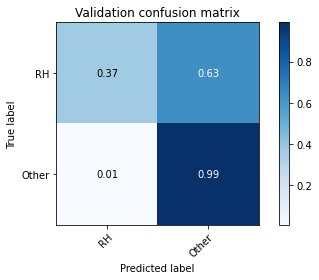

/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 1


/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


Train  Loss: 0.36747
Train  Accuracy: 83.5%
Valid  Loss: 0.70827
Valid  Accuracy: 69.2%
model saved
[[ 389  619]
 [  14 1030]]
Normalized confusion matrix


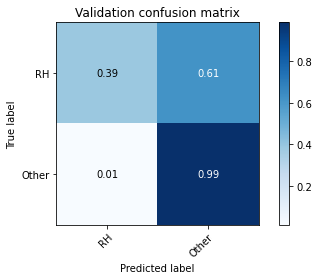

/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 2


/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


Train  Loss: 0.30920
Train  Accuracy: 87.2%
Valid  Loss: 0.72429
Valid  Accuracy: 69.5%
model saved
[[ 398  610]
 [  15 1029]]
Normalized confusion matrix


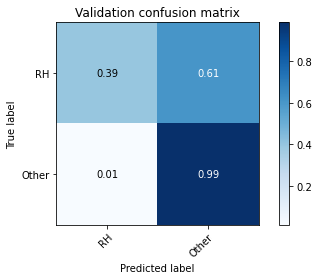

/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 3


/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


Train  Loss: 0.26861
Train  Accuracy: 89.7%
Valid  Loss: 0.71719
Valid  Accuracy: 70.5%
model saved
[[ 424  584]
 [  21 1023]]
Normalized confusion matrix


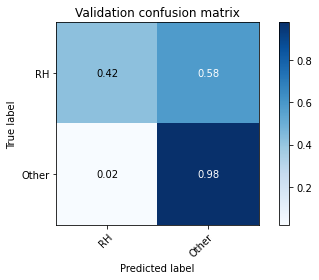

/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 4


/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


Train  Loss: 0.23228
Train  Accuracy: 91.4%
Valid  Loss: 0.77557
Valid  Accuracy: 70.1%
Epoch 5
Train  Loss: 0.20311
Train  Accuracy: 93.0%
Valid  Loss: 0.78893
Valid  Accuracy: 71.2%
model saved
[[ 440  568]
 [  24 1020]]
Normalized confusion matrix


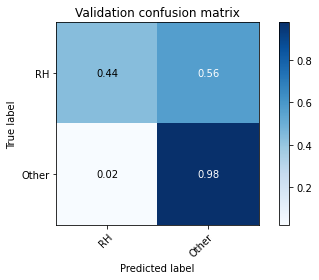

/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 6


/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


Train  Loss: 0.17364
Train  Accuracy: 94.5%
Valid  Loss: 0.83329
Valid  Accuracy: 70.8%
Epoch 7
Train  Loss: 0.14723
Train  Accuracy: 96.0%
Valid  Loss: 0.91638
Valid  Accuracy: 70.6%
Epoch 8
Train  Loss: 0.12585
Train  Accuracy: 96.7%
Valid  Loss: 0.90447
Valid  Accuracy: 71.9%
model saved
[[ 459  549]
 [  27 1017]]
Normalized confusion matrix


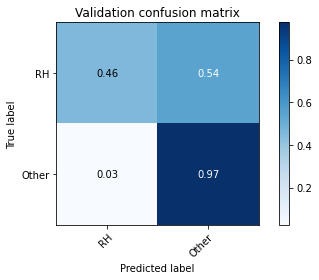

/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 9


/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


Train  Loss: 0.10422
Train  Accuracy: 97.5%
Valid  Loss: 0.96194
Valid  Accuracy: 72.1%
model saved
[[ 461  547]
 [  25 1019]]
Normalized confusion matrix


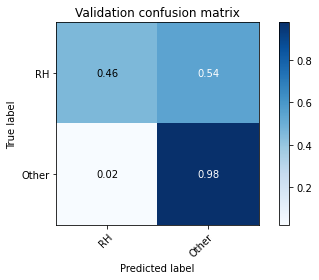

/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 10


/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


Train  Loss: 0.08876
Train  Accuracy: 98.1%
Valid  Loss: 1.00057
Valid  Accuracy: 73.1%
model saved
[[ 490  518]
 [  33 1011]]
Normalized confusion matrix


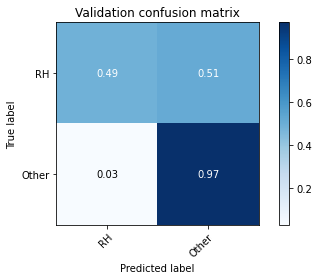

/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 11


/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


Train  Loss: 0.07181
Train  Accuracy: 98.7%
Valid  Loss: 1.05586
Valid  Accuracy: 73.5%
model saved
[[ 499  509]
 [  34 1010]]
Normalized confusion matrix


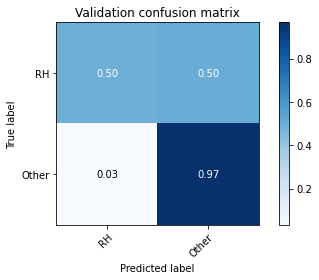

/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:66: UserWarning: np_to_var has been renamed np_to_th, please use np_to_th instead
  warn("np_to_var has been renamed np_to_th, please use np_to_th instead")


Epoch 12


/home/hainguyen/miniconda3/envs/eggnet/lib/python3.10/site-packages/braindecode/util.py:107: UserWarning: var_to_np has been renamed th_to_np, please use th_to_np instead
  warn("var_to_np has been renamed th_to_np, please use th_to_np instead")


Train  Loss: 0.06109
Train  Accuracy: 98.9%
Valid  Loss: 1.11512
Valid  Accuracy: 73.2%
Epoch 13
Train  Loss: 0.05017
Train  Accuracy: 99.3%
Valid  Loss: 1.20905
Valid  Accuracy: 72.5%
Epoch 14
Train  Loss: 0.04149
Train  Accuracy: 99.4%
Valid  Loss: 1.25387
Valid  Accuracy: 72.7%
Epoch 15
Train  Loss: 0.03511
Train  Accuracy: 99.5%
Valid  Loss: 1.26258
Valid  Accuracy: 72.8%
Epoch 16
Train  Loss: 0.02901
Train  Accuracy: 99.7%
Valid  Loss: 1.33137
Valid  Accuracy: 72.7%
Epoch 17
Train  Loss: 0.02459
Train  Accuracy: 99.7%
Valid  Loss: 1.37426
Valid  Accuracy: 72.1%
Epoch 18
Train  Loss: 0.02086
Train  Accuracy: 99.8%
Valid  Loss: 1.38541
Valid  Accuracy: 72.7%
Epoch 19
Train  Loss: 0.01822
Train  Accuracy: 99.8%
Valid  Loss: 1.52920
Valid  Accuracy: 70.9%
Epoch 20
Train  Loss: 0.01571
Train  Accuracy: 99.9%
Valid  Loss: 1.53788
Valid  Accuracy: 71.7%
Epoch 21
Train  Loss: 0.01403
Train  Accuracy: 99.8%
Valid  Loss: 1.52692
Valid  Accuracy: 72.6%
Epoch 22
Train  Loss: 0.01293
Train  Ac

In [11]:
batch_size = 128
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.5*0.001)

total_epoch = -1
Tlosses, Taccuracies = [], []
Vlosses, Vaccuracies = [], []
highest_acc = 0

savename = "demo.pth"

start=time.time()

for i_epoch in range(50):
    total_epoch += 1
    # Randomize batches ids and get iterater 'i_trials_in_batch'
    i_trials_in_batch = get_balanced_batches(len(train_set.X), rng, shuffle=True,
                                             batch_size=batch_size)
    # Set model to training mode
    model.train()
    for i_trials in i_trials_in_batch:
        # Have to add empty fourth dimension to X for training
        batch_X = train_set.X[i_trials][:, :, :, None]
        batch_y = train_set.y[i_trials]
        # convert from nparray to torch tensor
        net_in = np_to_var(batch_X)
    
        if cuda:
            net_in = net_in.cuda()
        net_target = np_to_var(batch_y)
        if cuda:
            net_target = net_target.cuda()
        # Remove gradients of last backward pass from all parameters
        optimizer.zero_grad()
        # Compute outputs of the network
        outputs = model(net_in)
        # Compute the loss
        loss = F.nll_loss(outputs, net_target)
        # Do the backpropagation
        loss.backward()
        # Update parameters with the optimizer
        optimizer.step()
    
    # Set model to evaluation mode
    model.eval()
    print("Epoch {:d}".format(total_epoch))
    average_acc = []
    average_loss = []
    
    # Here we compute training accuracy and validation accuracy of current model
    for setname, dataset in (('Train', train_set), ('Valid', valid_set)):
        i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False,
                                                 batch_size=batch_size)
        outputs=None
        for i_trials in i_trials_in_batch:
            batch_X = dataset.X[i_trials][:, :, :, None]
            batch_y = dataset.y[i_trials]
            net_in = np_to_var(batch_X)
            if cuda:
                net_in = net_in.cuda()
            toutputs = model(net_in)
            if outputs is None:
                temp = toutputs.cpu()
                outputs = temp.detach().numpy()
            else:
                temp = toutputs.cpu()
                outputs = np.concatenate((outputs,temp.detach().numpy()))
        net_target = np_to_var(dataset.y)
        loss = F.nll_loss(torch.from_numpy(outputs), net_target)
        print("{:6s} Loss: {:.5f}".format(
            setname, float(var_to_np(loss))))
        predicted_labels = np.argmax((outputs), axis=1)
        accuracy = np.mean(dataset.y  == predicted_labels)
        
        print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
        if setname == 'Train':
            Tlosses.append(loss)
            Taccuracies.append(accuracy)
            current_Tacc=accuracy
        elif setname == 'Valid':
            Vlosses.append(loss)
            Vaccuracies.append(accuracy)
            if accuracy>=highest_acc:
                torch.save({
                    'in_chans': in_chans,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'n_classes': labelsize,
                    'input_time_length': window_size
                }, savename)

                highest_acc=accuracy
                print('model saved')
                # plot_confusion_matrix(dataset.y, predicted_labels, 
                #                       classes=['LH', 'RH', 'Other'], normalize=True,
                #                       title='Validation confusion matrix')
                # plt.show()
                plot_confusion_matrix(dataset.y, predicted_labels, 
                                      classes=['RH', 'Other'], normalize=True,
                                      title='Validation confusion matrix')
                plt.show()
        else:
            average_acc.append(accuracy)
            average_loss.append(accuracy)
end = time.time()

print('time is {}'.format(end-start))

Here we can observe that on training set, the classification accuracy is fairly high, while it is usually not able to generalised well to the new subject directly with this simple strategy, this subject is just a well-performed case for tutorial purpose. Usually validation and test accuracy of a new subject decrease a lot (sometimes 30% or even more). Transfer learning strategies should be used to solve this problem.

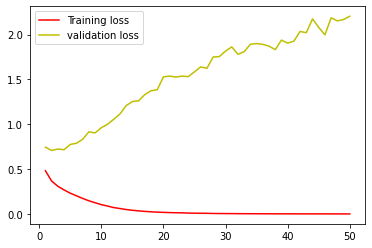

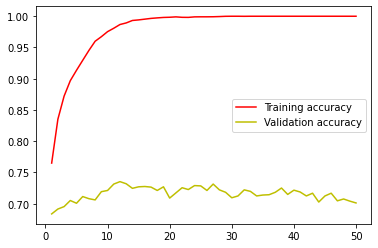

In [12]:
t = np.arange(0.0, len(Tlosses), 1)+1
plt.plot(t, Tlosses, 'r', t, Vlosses, 'y')
plt.legend(('Training loss', 'validation loss'))
plt.show()

plt.plot(t, Taccuracies, 'r', t, Vaccuracies, 'y')
plt.legend(('Training accuracy', 'Validation accuracy'))
plt.show()

testset Loss: 1.05586
testset Accuracy: 73.5%
[[ 499  509]
 [  34 1010]]
Normalized confusion matrix


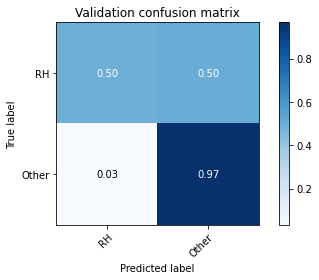

In [13]:
model = util.shallow_net.EEGShallowClassifier(in_chans, labelsize, window_size, return_feature=False)
if cuda:
    model.cuda()
checkpoint = torch.load(savename)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

average_acc, average_loss = [], []
setname = 'testset'
dataset = test_set

i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False,
                                         batch_size=batch_size)
outputs=None
for i_trials in i_trials_in_batch:
    # Have to add empty fourth dimension to X
    batch_X = dataset.X[i_trials][:, :, :, None]
    batch_y = dataset.y[i_trials]
    net_in = np_to_var(batch_X)
    if cuda:
        net_in = net_in.cuda()
    toutputs = model(net_in)
    if outputs is None:
        temp = toutputs.cpu()
        outputs = temp.detach().numpy()
    else:
        temp = toutputs.cpu()
        outputs = np.concatenate((outputs,temp.detach().numpy()))

net_target = np_to_var(dataset.y)
loss = F.nll_loss(torch.from_numpy(outputs), net_target)
print("{:6s} Loss: {:.5f}".format(setname, float(var_to_np(loss))))
predicted_labels = np.argmax((outputs), axis=1)
accuracy = np.mean(dataset.y  == predicted_labels)

print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
plot_confusion_matrix(dataset.y, predicted_labels, 
                      classes=['RH','Other'], normalize=True,
                      title='Validation confusion matrix')
plt.show()